In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Capstone-Dataset')
root_path = '/content/gdrive/My Drive/Capstone-Dataset/'

Mounted at /content/gdrive


In [4]:
train_dir = os.path.join(root_path, 'train')
validation_dir = os.path.join(root_path, 'validation')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    shuffle=True,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                               shuffle=True,
                                                               batch_size=20,
                                                               color_mode='rgb',
                                                               class_mode  = 'categorical',
                                                               target_size = (150, 150))

Found 1329 images belonging to 7 classes.
Found 132 images belonging to 7 classes.


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-03 15:08:07--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 142.250.152.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   231MB/s    in 0.4s    

2022-06-03 15:08:07 (231 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
def create_pre_trained_model(local_weights_file):
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [9]:
pre_trained_model = create_pre_trained_model(local_weights_file)

In [10]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [11]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [12]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(7, activation='softmax')(x)       

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer = 'adam', 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [13]:
model = create_final_model(pre_trained_model, last_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [14]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    verbose = 2,
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    validation_steps = validation_generator.samples // validation_generator.batch_size)

Epoch 1/50
66/66 - 363s - loss: 2.5580 - accuracy: 0.3789 - val_loss: 1.1621 - val_accuracy: 0.5583 - 363s/epoch - 6s/step
Epoch 2/50
66/66 - 15s - loss: 1.2152 - accuracy: 0.5280 - val_loss: 0.9627 - val_accuracy: 0.6250 - 15s/epoch - 227ms/step
Epoch 3/50
66/66 - 15s - loss: 1.1018 - accuracy: 0.5714 - val_loss: 1.0770 - val_accuracy: 0.5917 - 15s/epoch - 223ms/step
Epoch 4/50
66/66 - 15s - loss: 1.0406 - accuracy: 0.5875 - val_loss: 0.9311 - val_accuracy: 0.6667 - 15s/epoch - 222ms/step
Epoch 5/50
66/66 - 15s - loss: 0.9995 - accuracy: 0.6180 - val_loss: 0.9764 - val_accuracy: 0.6667 - 15s/epoch - 223ms/step
Epoch 6/50
66/66 - 15s - loss: 0.9579 - accuracy: 0.6234 - val_loss: 0.8014 - val_accuracy: 0.7250 - 15s/epoch - 222ms/step
Epoch 7/50
66/66 - 15s - loss: 0.9305 - accuracy: 0.6532 - val_loss: 0.8496 - val_accuracy: 0.7167 - 15s/epoch - 221ms/step
Epoch 8/50
66/66 - 15s - loss: 0.8762 - accuracy: 0.6723 - val_loss: 0.7933 - val_accuracy: 0.7500 - 15s/epoch - 222ms/step
Epoch 9/5

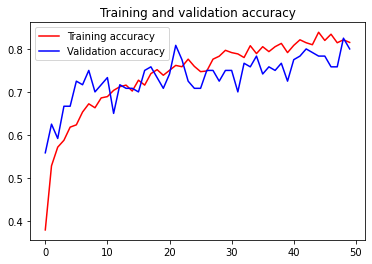

<Figure size 432x288 with 0 Axes>

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [16]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded=files.upload()

for fn in uploaded.keys():
 
  root_path = '/content/gdrive/My Drive/Capstone-Dataset/'
  path = root_path + fn
  img = image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][0]:
    print(fn + " is alopecia_areata")
  elif max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][1]:
    print(fn + " is dandruff")
  elif max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][2]:
    print(fn + " is folliculitis")
  elif max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][3]:
    print(fn + " is healthy_scalp")
  elif max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][4]:
    print(fn + " is psoriasis")
  elif max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][5]:
    print(fn + " is seborrheic_dermatitis")
  elif max([classes[0][0], classes[0][1], classes[0][2], classes[0][3], classes[0][4], classes[0][5], classes[0][6]]) == classes[0][6]:
    print(fn + " is tinea_capitis")

Saving alopecia.jpg to alopecia (7).jpg
Saving alopecia2.jpg to alopecia2 (7).jpg
Saving alopecia3.jpg to alopecia3 (7).jpg
Saving dandruff (2).jpg to dandruff (2) (12).jpg
Saving dandruff.jpg to dandruff (13).jpg
Saving dandruff2.jpg to dandruff2 (7).jpg
Saving dandruff3.jpg to dandruff3 (7).jpg
Saving foli_alo.jpg to foli_alo (12).jpg
Saving foli_pso.jpg to foli_pso (7).jpg
Saving healthy.jpg to healthy (7).jpg
Saving lichen1.jpg to lichen1 (17).jpg
Saving pso.jpg to pso (14).jpg
Saving pso1.jpg to pso1 (19).jpg
Saving pso2.jpg to pso2 (11).jpg
Saving sebo1.jpg to sebo1 (16).jpg
Saving sebor.jpg to sebor (7).jpg
Saving tinea.jpg to tinea (17).jpg
Saving tinea2.jpg to tinea2 (7).jpg
Saving tinea3.jpg to tinea3 (7).jpg
[9.9999511e-01 9.6748591e-14 3.5123793e-14 4.6923093e-10 2.1964642e-15
 1.6428354e-13 4.8779875e-06]
alopecia.jpg is alopecia_areata
[8.5442883e-01 7.3435808e-06 8.7761582e-04 8.0450810e-04 1.0476480e-06
 8.3691317e-05 1.4379695e-01]
alopecia2.jpg is alopecia_areata
[1.5

In [ ]:
model.save(root_path + "/model/{}".format('Categorical-adam_default-Capstone-Project-C22PS22-fix'))

In [ ]:
import pathlib

export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./Categorical_Adam_fix.tflite')
tflite_model_file.write_bytes(tflite_model)

In [19]:
model.save('Categorical_Adam_fix.h5')